# Py: Socio-Economic Index Construction
**This notebook was originally created by Andres Villegas Ramirez for the Data Analytics Applications subject, as *Case study 1 - The Socio-Economic Indexes for Areas*  in the *DAA M06 Unsupervised learning* module.**

**The Data Analytics Application is a Fellowship Applications (Module 3) subject with the Actuaries Institute that aims to teach students how to apply a range of data analytics skills, such as neural networks, natural language processing, unsupervised learning and optimisation techniques, together with their professional judgement, to solve a variety of complex and challenging business problems. The business problems used as examples in this subject are drawn from a wide range of industries.**

**Find out more about the course [here](https://www.actuaries.asn.au/education-program/fellowship/subjects-and-syllabus/data-analytics-applications-subject).**

### Purpose:
This case study demonstrates the use of principal component analysis (PCA) in the construction of an index to rank the socio-economic status of different geographical areas within a country. Such an index can be useful to identify areas that require funding or services, or as input for research into the relationship between socio-economic conditions and other outcomes in different areas.

In Australia, the Australian Bureau of Statistics (ABS) produces such indexes, referred to as the Socio-Economic Indexes for Areas (SEIFA). SEIFA rank areas in Australia based on their relative socio-economic advantage and disadvantage.

This notebook replicates the methodology adopted by the ABS in constructing one of these indexes, namely the Index of Relative Socio-Economic Disadvantage (IRSD). 

Read pages 15 to 20 of the SEIFA technical document: https://www.abs.gov.au/ausstats/subscriber.nsf/log?openagent&SEIFA%202016%20Technical%20Paper.pdf&2033.0.55.001&Publication&756EE3DBEFA869EFCA258259000BA746&&2016&27.03.2018&Latest.

### References:
In Australian Government data, there are three different levels that are used to group geographical areas together:
•	Statistical Area Level 1 (SA1);
•	Statistical Area Level 2 (SA2); and
•	Statistical Area Level 3 (SA3).
SA1 is the most granular level, with each SA1 having an average population of approximately 400 people. Most of the data generated from the ABS Census is available at SA1. SA1s are referred to by number only. Each SA2 is similar in size to suburbs, and these are referred to by suburb names. Each SA3 is a region of Australia.

For this PCA exercise, each observation is an SA1. The features for each SA1 that are used in the index are the following derived variables based on the Australian Census data for 2016 (https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/2071.02016?OpenDocument):
- inc_low:	% people with stated annual household equivalised income between 1 and 25,999 dollars;
- childjobless:	% families with children under 15 years of age who live with jobless parents;
- nonet:	% occupied private dwellings with no Internet connection;
- noyr12higher:	% people aged 15 years and over whose highest level of education is Year 11 or lower;
- unemployed:	% people (in the labour force) unemployed;
- lowrent:	% occupied private dwellings paying rent less than 215 dollars per week (excluding $0 per week);
- oneparent:	% one-parent families with dependent offspring only;
- disabilityu70:	% people aged under 70 who have a long-term health condition or disability and need assistance with core activities;
- sepdivorced:	% people aged 15 and over who are separated or divorced;
- nocar:	% occupied private dwellings with no cars;
- noedu:	% people aged 15 years and over who have no educational attainment;
- englishpoor:	% people who do not speak English well;
- labour:	% employed people classified as ‘labourers’;
- drivers:	% employed people classified as Machinery Operators and Drivers; and
- service:	% employed people classified as Low Skill Community and Personal Service workers.



## Packages
This section installs packages that will be required for this exercise/case study.

In [1]:
# Import pandas and numpy for data management.
import numpy as np
import pandas as pd

# Import library functions that will be required for the PCA modelling.
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# For calculating correlation between the ABS index and the recreated index.
from scipy.stats import pearsonr


## Functions
This section defines functions that will be used for this exercise/case study.

In [2]:
# Define a function to obtain the explained variances from the PCA features.
def plot_explained_variances(pca):

    exp_var_pca = pca.explained_variance_ratio_

    # Calculate the cumulative sum of variances explained.
    # This will be used to create a scree plot for visualising the variance
    # explained by each principal component.

    cum_sum_var = np.cumsum(exp_var_pca)
    
    # Create the plot
    plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center',
            label='Individual explained variance',color='dodgerblue')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

## Data
This section:
- imports the data that will be used in the modelling;
- explores the data; and
- prepares the data for modelling.

### Import data

In [3]:
# Specify the folder that your datasets are saved in.
# or here, read it from the URL 
infolder = 'https://actuariesinstitute.github.io/cookbook/_static/daa_datasets/'

In [4]:
# Import the data files for the case study.
# The first data set ('file1' below) contains the features to be used in the 
# modelling for each SA1.
# The second data set ('file2' below) contains the ABS's reported
# IRSD index value for each SA1 which will be used later for comparison to
# the index derived in this notebook.

# Specify the filenames.
file1 = 'DAA_M06_CS1_data1.csv'
file2 = 'DAA_M06_CS1_data2.xls'

# Read in the data from your folder.
data1 = pd.read_csv(infolder+file1)
data2 = pd.read_excel(infolder+file2, sheet_name='Table 1', header = 5,
                      usecols='A:C',
                      names = ['SA1_7DIGITCODE_2016', 'SA1_11DIGITCODE_2016', 'IRSD_ABS'])

### Explore data (EDA)

In [5]:
data1.head()

,SA1_7DIGITCODE_2016,inc_low_perc,childjobless_perc,nonet_perc,noyr12higher_perc,unemployed_perc,lowrent_perc,oneparent_perc,disabilityu70_perc,sepdivorced_perc,nocar_perc,noedu_perc,englishpoor_perc,labour_perc,drivers_perc,service_perc
0,1100701,0.240000,0.000000,0.220000,0.468900,0.039604,0.000000,0.0,0.016667,0.154206,0.030000,0.000000,0.000000,0.135417,0.083333,0.031250
1,1100702,0.190083,0.064516,0.165289,0.374593,0.035714,1.000000,0.0,0.028736,0.125786,0.024793,0.000000,0.008824,0.085366,0.054878,0.067073
2,1100703,0.163743,0.000000,0.210526,0.402516,0.072165,0.175439,0.0,0.025510,0.182099,0.035088,0.000000,0.015228,0.117318,0.067039,0.111732
3,1100704,0.192771,0.000000,0.162651,0.357542,0.052941,0.320000,0.0,0.061497,0.197222,0.048193,0.000000,0.012690,0.066265,0.060241,0.084337
4,1100705,0.183544,0.000000,0.253165,0.453674,0.071038,0.185185,0.0,0.021622,0.223565,0.018987,0.011111,0.008264,0.091954,0.114943,0.109195


In [6]:
data2.head()

,SA1_7DIGITCODE_2016,SA1_11DIGITCODE_2016,IRSD_ABS
0,1100701,1.010210e+10,991
1,1100702,1.010210e+10,1044
2,1100703,1.010210e+10,980
3,1100704,1.010210e+10,984
4,1100705,1.010210e+10,944


### Prepare data

#### Dataset 1

In [7]:
# Drop the first column of dataset 1 for the purposes of the PCA analysis.
pca_data = data1.iloc[:,1:]

# Scale the features in dataset 1.
sc = StandardScaler()
sc.fit(pca_data)
pca_data = sc.transform(pca_data)

print(data1[0:5])
print(pca_data[0:5])

   SA1_7DIGITCODE_2016  inc_low_perc  childjobless_perc  nonet_perc  \
0              1100701      0.240000           0.000000    0.220000   
1              1100702      0.190083           0.064516    0.165289   
2              1100703      0.163743           0.000000    0.210526   
3              1100704      0.192771           0.000000    0.162651   
4              1100705      0.183544           0.000000    0.253165   

   noyr12higher_perc  unemployed_perc  lowrent_perc  oneparent_perc  \
0           0.468900         0.039604      0.000000             0.0   
1           0.374593         0.035714      1.000000             0.0   
2           0.402516         0.072165      0.175439             0.0   
3           0.357542         0.052941      0.320000             0.0   
4           0.453674         0.071038      0.185185             0.0   

   disabilityu70_perc  sepdivorced_perc  nocar_perc  noedu_perc  \
0            0.016667          0.154206    0.030000    0.000000   
1           

#### Dataset 2

In [8]:
# Remove the second column ('SA1_11DIGITCODE_2016') of dataset 2
# as this is not needed in the analysis.
# Also, the last row in the dataset is a blank row, so this will also be
# removed.
ABS_IRSD_S1 = data2.iloc[:-2,[0,2]]

# Convert the ABS_IRSD features to be numeric.
ABS_IRSD_S1['IRSD_ABS'] = pd.to_numeric(ABS_IRSD_S1['IRSD_ABS'],
                                        errors='coerce')
ABS_IRSD_S1['SA1_7DIGITCODE_2016'] = pd.to_numeric(ABS_IRSD_S1['SA1_7DIGITCODE_2016'],
                                        errors='coerce', downcast='integer')


# Drop any SA1s with missing values in the dataset.
ABS_IRSD_S1 = ABS_IRSD_S1.dropna()

print(ABS_IRSD_S1.info())
print(ABS_IRSD_S1.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55028 entries, 0 to 55139
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SA1_7DIGITCODE_2016  55028 non-null  int32  
 1   IRSD_ABS             55028 non-null  float64
dtypes: float64(1), int32(1)
memory usage: 1.0 MB
None
   SA1_7DIGITCODE_2016  IRSD_ABS
0              1100701     991.0
1              1100702    1044.0
2              1100703     980.0
3              1100704     984.0
4              1100705     944.0


## Modelling
This section performs the PCA to recreate the ABS's Index of Relative Socio-Economic Disadvantage (IRSD).

### Fit the model

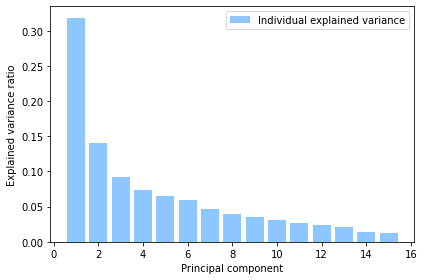

In [9]:
# Initiate the PCA.
pca = PCA()

# Fit the PCA model to determine the transformed features.
pca.fit_transform(pca_data)

# Use the 'plot_explained_variances' function defined at the top of the
# notebook to plot the variance explained by each principal component.
plot_explained_variances(pca)

Principal component 1 (PC1) explains over 30% of the variance in the data. PC1 is used as the basis of calculating the IRSD. 

In [10]:
# Print out the weights from the first principal component.
print(pca.components_[0])

[0.36072468 0.08131692 0.38518693 0.31052255 0.2933824  0.28582244
 0.00381553 0.31111068 0.28224429 0.19477958 0.14916194 0.07718385
 0.33772077 0.24373008 0.18609863]


In [11]:
# Apply the PCA dimensionality reduction on the original dataset.
# Note that in the step below, all the calculated principal components
# are multipled by -1, to align with the approach used by the ABS
# where disadvantage indicators, such as the features used in this
# case study, are given negative rather than positive weights.
# This is described further on page 18 of the SEIFA technical paper. 

pca_data_transformed = -1.0*pca.fit_transform(pca_data)
    
print(pca_data_transformed[:,0])

[-0.15624479 -0.49972447 -0.5528763  ... -1.18432177 -2.39454824
  0.34480264]


In [12]:
# Merge principal component 1 (PC1) with the original dataset so that
# each SA1 is matched with its calculated raw IRSD index value.
pca1 = pd.DataFrame(pca_data_transformed[:,0], columns = ['IRSD_raw'])

IRSD_S1 = pd.concat([data1['SA1_7DIGITCODE_2016'].reset_index(drop=True), pca1]
                    , axis=1)

# Print the first 5 observations in the new dataset which shows the
# raw IRSD index value for each SA1.
print(IRSD_S1.head())


   SA1_7DIGITCODE_2016  IRSD_raw
0              1100701 -0.156245
1              1100702 -0.499724
2              1100703 -0.552876
3              1100704 -0.566873
4              1100705 -1.266919


In [13]:
# Rescale the raw IRSD index values to have a mean of 1,000 and a
# standard deviation of 100.
IRSD_S1['IRSD_recreated'] = (IRSD_S1['IRSD_raw']/IRSD_S1['IRSD_raw'].std())*100+1000

# Print the first 5 observations to see their scaled IRSD index values.
print(IRSD_S1.head())

   SA1_7DIGITCODE_2016  IRSD_raw  IRSD_recreated
0              1100701 -0.156245      992.854948
1              1100702 -0.499724      977.147669
2              1100703 -0.552876      974.717043
3              1100704 -0.566873      974.076956
4              1100705 -1.266919      942.063949


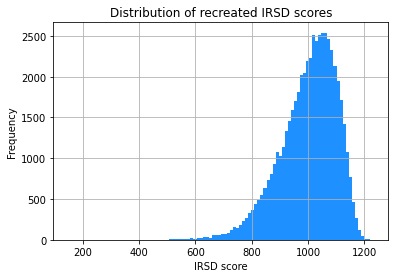

In [14]:
# Plot a histogram to show the distribution of IRSD_scaled index values
# across all the SA1s.
IRSD_S1.hist(column='IRSD_recreated', bins=100, color='dodgerblue')
plt.title('Distribution of recreated IRSD scores')
plt.xlabel('IRSD score')
plt.ylabel('Frequency')

plt.show()
#plt.savefig('DAA_M06_Fig11.jpg')

### Evaluate the model
This section compares the created IRSD indexes to those published by the ABS to see how well this notebook has replicated the ABS index.

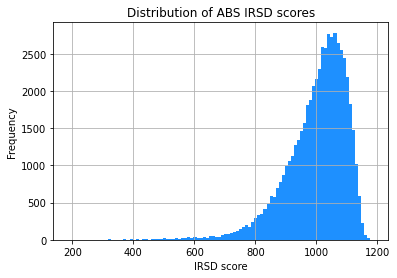

In [15]:
# Plot a histogram to show the distribution of the ABS IRSD index values
# across all the SA1s.
ABS_IRSD_S1.hist(column='IRSD_ABS', bins=100, color='dodgerblue')
plt.title('Distribution of ABS IRSD scores')
plt.xlabel('IRSD score')
plt.ylabel('Frequency')

plt.show()

The two histograms look very similar. This is promising!

In [16]:
# Join the two datasets together to compare the IRSD calculated to the ABS
# published IRSD.

IRSD_join = pd.merge(ABS_IRSD_S1, IRSD_S1, how = 'inner', on = 'SA1_7DIGITCODE_2016')

print(IRSD_join.head())

   SA1_7DIGITCODE_2016  IRSD_ABS  IRSD_raw  IRSD_recreated
0              1100701     991.0 -0.156245      992.854948
1              1100702    1044.0 -0.499724      977.147669
2              1100703     980.0 -0.552876      974.717043
3              1100704     984.0 -0.566873      974.076956
4              1100705     944.0 -1.266919      942.063949


A quick look at the first 5 SA1s in the dataset shows that the ABS's IRSD index values and the values calculated in this notebook are very close for some of the SA1 (in the example above SA1 1100701, 1100703, 1100704 and 1100705), but different for others (e.g. SA1 2200702 which has a much higher ABS index).

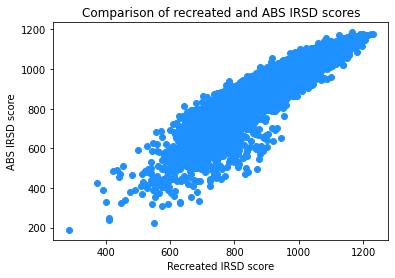

In [17]:
# Create a scatter plot to see how well the recreated index aligns with the ABS
# index, even if the individual index values aren't the same for all SA1s.
plt.scatter('IRSD_recreated', 'IRSD_ABS', data=IRSD_join, color='dodgerblue')
plt.title('Comparison of recreated and ABS IRSD scores')
plt.xlabel('Recreated IRSD score')
plt.ylabel('ABS IRSD score')

plt.show()

#plt.savefig('DAA_M06_Fig12.jpg')

The above scatter plot shows that the two sets of indexes are broadly aligned.

In [18]:
# Calculate the correlation between the ABS index and the index calculated
# in this notebook.
correlation, _ = pearsonr(IRSD_join['IRSD_recreated'], IRSD_join['IRSD_ABS'])
print('The correlation between the ABS and recreated index is: '+str(correlation))

The correlation between the ABS and recreated index is: 0.9455521726857933


## Commentary

The recreated index appears to be very similar the ABS index, with a high correlation between index values (94.6%).